# Risk Parity Portfolios

Q: If you compare a cap weighted index (e.g., the S&P500) to an equal risk contribution portfolio based on the same universe, would you expect to have for the ERC portfolio:

A: Higher ENC & higher ENCB

ERC portfolio tend to be better diversified compared to CW portfolios, so ENC is generally higher. Besides, ENCB will be 100% for the ERC portfolio   

Risk parity portfolios are constructed so that each component has the same contribution to portfolio risk

They are extremely popular in practice because they <mark>tend to be more risk efficient</mark> than traditional market benchmarks.

# Comparing Diversification Options

Cap-Weighted benchmarks are not the most efficient portfolios because of their Excessive Concentration.

One can use a variety of diversification methodologies to build more efficient portfolios. Including Equally-Weighted. Minimum variance and risk parity portfolios.

# Risk Contributions and Risk Parity

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2

inds = ['Food','Beer','Smoke','Games','Books','Hshld','Clths','Hlth',
        'Chems','Txtls','Cnstr','Steel','FabPr','ElcEq','Autos','Carry',
        'Mines','Coal','Oil','Util','Telcm','Servs','BusEq','Paper','Trans',
        'Whlsl','Rtail','Meals','Fin','Other']
inds = ['Beer','Hlth','Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting='vw', n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49,weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [2]:
def risk_contribution(w,cov):
    """compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance"""
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

<Axes: title={'center': 'risk_contributions of an EW portfolio'}>

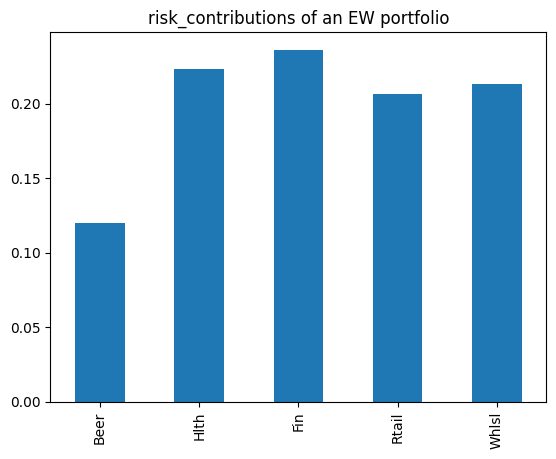

In [3]:
risk_contribution(erk.weight_ew(rets),cov).plot.bar(title='risk_contributions of an EW portfolio')

In [4]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """Returns the weights of the portfolio that gives you the weights such athat the contributions,
    to portfolio risk are as close as possible to the target_risk, given the covariance matrix"""
    n=cov.shape[0]
    init_guess=np.repeat(1/n,n)
    bounds=((0.0,1.0),)*n # an N-tuple of 2-tuples!
    #construct the constraints
    weights_sum_to_1={'type':'eq',
                      'fun':lambda weights: np.sum(weights)-1}
    def msd_risk(weights, target_risk,cov):
        """
        Returns the mean squared difference in risk contributions
        between weights and target_risk"""
        w_contribs=risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights=minimize(msd_risk, init_guess,
                     args=(target_risk,cov), method='SLSQP',
                     options={'disp':False},
                     constraints=(weights_sum_to_1,),
                     bounds=bounds)
    return weights.x
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions of the constituents
    based on the given covariance matrix"""
    n=cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)



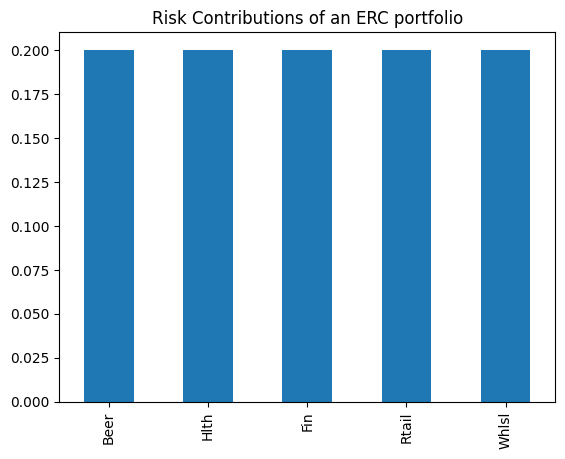

In [5]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [6]:
def weight_erc(r, cov_estimator=erk.sample_cov,**kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns"""
    est_cov = cov_estimator(r,**kwargs)
    return equal_risk_contributions(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418


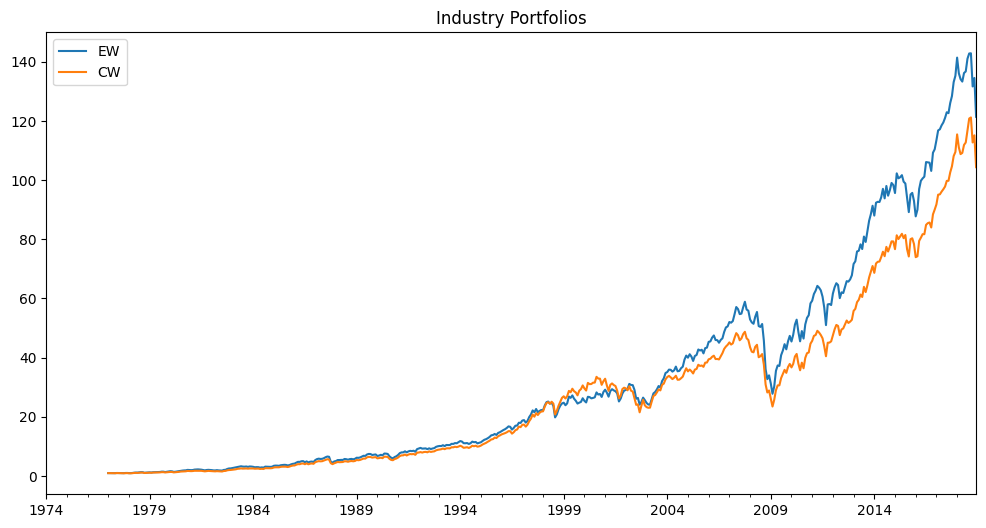

In [7]:
ewr=erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr=erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr=pd.DataFrame({"EW":ewr, "CW":cwr})
(1+btr).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


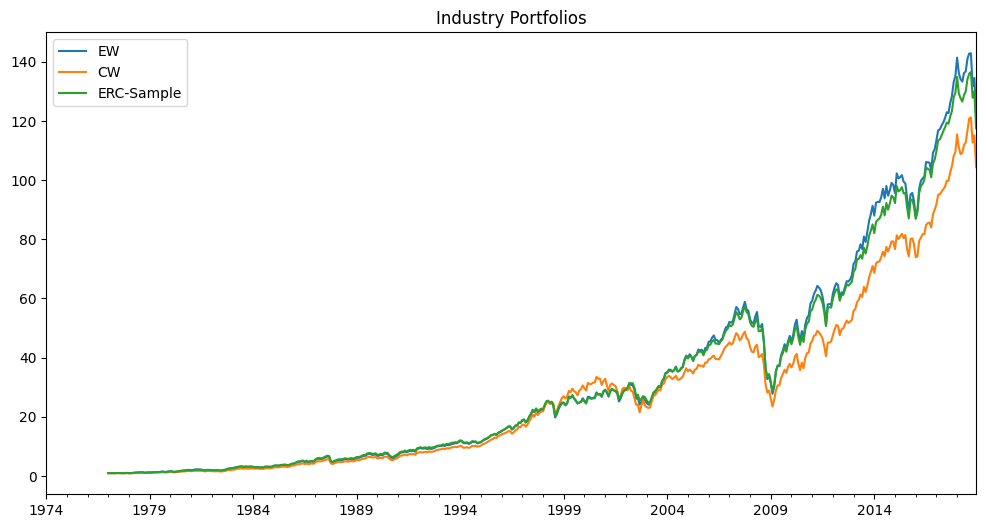

In [8]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW":ewr, "CW":cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Load the 49 Value Weighted industry portfolio returns. Limit the analysis to returns of the 49 VW portfolios from the most recent 5 years for which you have data i.e 2014-2018 both years inclusive. Also load the Market Caps of each of the 49 industries. Assume that the cap-weights as of the first month (2014-01) are the cap-weights we’ll use for this analysis.

Which Industry had the highest risk contribution in the cap-weighted portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. Hlth, Fin, Whlsl, Rtail, or Food)

In [9]:
import numpy as np
import pandas as pd

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
#inds=['Hlth','Fin','Whlsl','Rtail','Food']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":"2018"]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2014-01":]

rets = ind_rets
cov = rets.cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [11]:
risk_contribution(erk.weight_cw(rets, ind_mcap), cov).sort_values(ascending=False)

Banks    0.103966
Softw    0.098402
Drugs    0.089100
Oil      0.085238
Rtail    0.067192
Chips    0.062819
Telcm    0.045711
Other    0.041063
Insur    0.038640
Mach     0.030154
Fin      0.027692
Trans    0.026470
Chems    0.024999
BusSv    0.021439
Hardw    0.019333
Autos    0.016304
LabEq    0.015426
Aero     0.014875
Whlsl    0.013601
MedEq    0.013458
Hshld    0.011197
Paper    0.011071
Meals    0.010397
Util     0.010257
Food     0.010076
Fun      0.009801
ElcEq    0.007724
Cnstr    0.007450
Clths    0.006391
Smoke    0.006131
Soda     0.006043
BldMt    0.005933
Steel    0.005038
Beer     0.004937
Mines    0.004738
Hlth     0.004441
PerSv    0.003219
RlEst    0.002845
Agric    0.002749
Boxes    0.002599
Guns     0.002413
Rubbr    0.001939
Toys     0.001698
Ships    0.001365
Txtls    0.001290
Books    0.001166
Coal     0.000826
FabPr    0.000291
Gold     0.000094
dtype: float64

Use the same data as the previous question. What was the highest risk contribution from any one industry in the cap-weighted portfolio?

In [12]:
erk.risk_contribution(erk.weight_cw(rets, ind_mcap), cov).values.max()*100


10.396630266284635

Which Industry had the highest risk contribution in the equal-weighted portfolio?

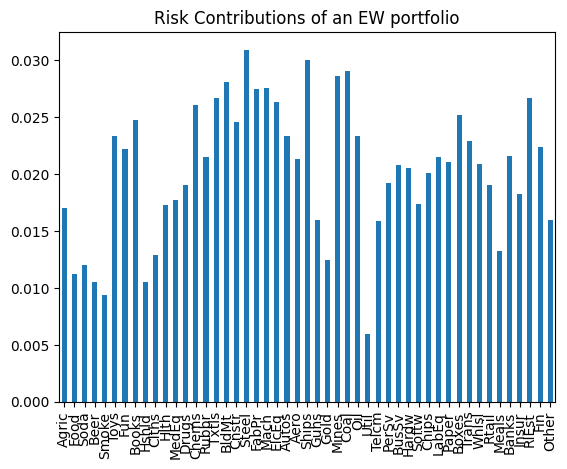

In [13]:
risk_contribution(erk.weight_ew(rets), cov).plot.bar(title="Risk Contributions of an EW portfolio");

In [14]:
risk_contribution(erk.weight_ew(rets, ind_mcap), cov).sort_values(ascending=False)

Steel    0.030938
Ships    0.030005
Coal     0.029025
Mines    0.028641
BldMt    0.028106
Mach     0.027558
FabPr    0.027473
RlEst    0.026693
Txtls    0.026679
ElcEq    0.026376
Chems    0.026042
Boxes    0.025176
Books    0.024772
Cnstr    0.024585
Oil      0.023372
Toys     0.023371
Autos    0.023338
Trans    0.022935
Fin      0.022416
Fun      0.022200
Banks    0.021622
Rubbr    0.021541
LabEq    0.021497
Aero     0.021306
Paper    0.021104
Whlsl    0.020881
BusSv    0.020757
Hardw    0.020570
Chips    0.020140
PerSv    0.019258
Drugs    0.019058
Rtail    0.019039
Insur    0.018249
MedEq    0.017747
Softw    0.017357
Hlth     0.017251
Agric    0.016982
Guns     0.015950
Other    0.015948
Telcm    0.015910
Meals    0.013261
Clths    0.012855
Gold     0.012449
Soda     0.012041
Food     0.011227
Beer     0.010500
Hshld    0.010492
Smoke    0.009393
Util     0.005916
dtype: float64

What was the highest risk contribution from any one industry in the equal-weighted portfolio?

In [15]:
erk.risk_contribution(erk.weight_ew(rets, ind_mcap), cov).values.max()*100


3.0937663971181446

Using the Sample Covariance over the 5 year period, compute the weights of the ERC portfolio. What sector portfolio is assigned the highest weight in the ERC portfolio?

In [16]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

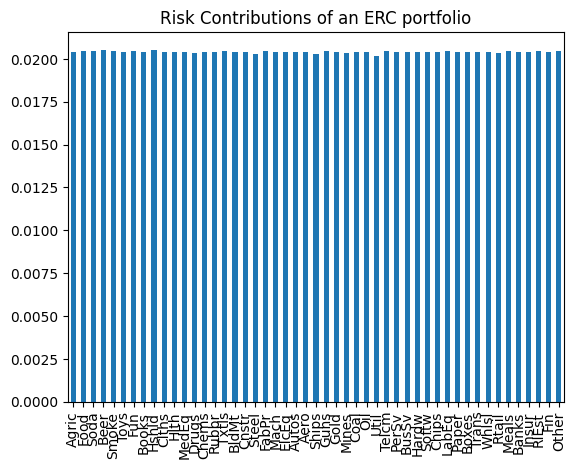

In [17]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [18]:
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

In [37]:
erc_w = pd.DataFrame(np.transpose(erk.equal_risk_contributions(cov)), index = rets.columns, columns=["Weight"] )
erc_w.sort_values(by='Weight',ascending=0)
#.sort_values(by='Weight',ascending=0) is based on the columns range from highest to lowest.

,Weight
Util,0.052156
Hshld,0.033184
Smoke,0.032606
Beer,0.032028
Food,0.030251
Clths,0.029129
Soda,0.028233
Meals,0.027907
Gold,0.027282
Guns,0.023809


Using the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) compute the weights of the ERC portfolio. What is the weight of the sector portfolio that is assigned the highest weight in the ERC portfolio?

In [38]:
erc_w.values.max()*100

5.215573493370011

Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio. What sector portfolio is assigned the lowest weight in the ERC portfolio?

In [39]:
erc_w.sort_values(by=['Weight'], ascending=True)


,Weight
Steel,0.012809
Ships,0.013041
BldMt,0.013790
Mines,0.013951
Mach,0.014292
RlEst,0.014429
Txtls,0.014440
ElcEq,0.014747
Coal,0.014759
Chems,0.014918


Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio.
What is the weight of the sector portfolio that is assigned the lowest weight in the ERC portfolio?

In [40]:
erc_w.values.min()*100

1.2809105063207988

Use the same data as you used in the previous question (Sample Covariance over the 5 year period and the initial capweights over that period).
In the cap-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

In [41]:
CW = erk.risk_contribution(erk.weight_cw(rets, ind_mcap),cov)
(CW.values.max()*100)-(CW.values.min()*100)

10.387213196831604

Use the same data as you used in the previous question (Sample Covariance over the 5  year period and the initial capweights over that period).
In the equal-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

In [42]:
EW = erk.risk_contribution(erk.weight_ew(rets, ind_mcap),cov)
(EW.values.max()*100)-(EW.values.min()*100)

2.502175762491148